In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_Village", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

it is showing the size of one batch

ie., there are 32 batches and each batches have 68 images

In [6]:
print(68*32)

2176


this is the actual size but may slightly vary because of irregular size of 3rd batch

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 1 0 0 0 1 0 1 1 0 2 1 2 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0]


this was of first batch

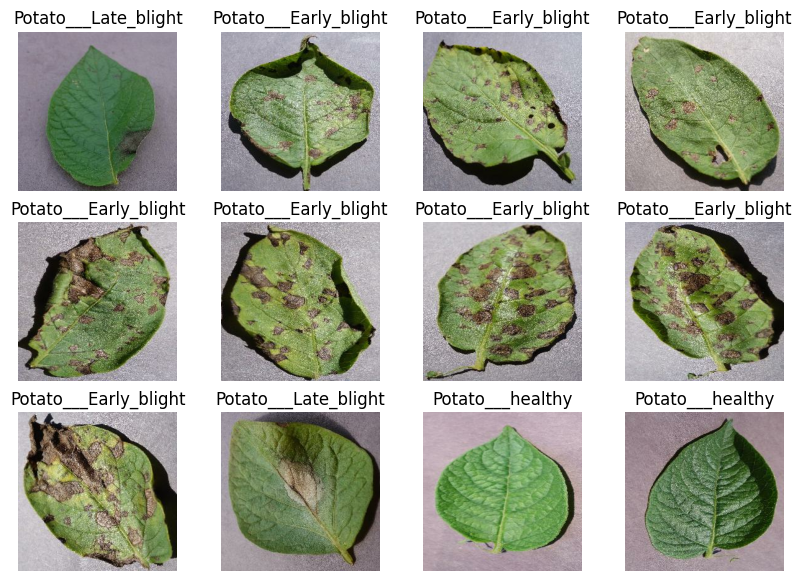

In [8]:
plt.figure(figsize = (10, 7))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% --> training
# 10% --> validation
# 10% --> testing

In [10]:
# train_size = 0.8
# validation_size = 0.1
# test_size = 0.1

In [11]:
# # len(dataset)*train_size

# ==>54.40000000000006

In [12]:
# train_ds = dataset.take(54)

In [13]:
# # len(train_ds)

# ==> 54

In [14]:
# test_ds = dataset.skip(54)
# #temporarily storing rest of the images as test in test_ds
# len(test_ds)

# ==> 14

In [15]:
# # validation_size * len(dataset)

# ==> 6.80000000000001

In [16]:
# # val_ds = test_ds.take(6)
# # len(val_ds)

# ==> 6

In [17]:
# # test_ds = test_ds.skip(6)
# # len(test_ds)

# ==> 8

In [18]:
def dataset_partitions_tf(ds, train_size = 0.8, val_size = 0.1, test_size = 0.1, shuffle = True, shuffle_size = 1000):
    dataset_size = len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size, seed = 12)
    
    train_ds_size = int(dataset_size * train_size)
    val_ds_size = int(dataset_size * val_size)
    test_ds_size = int(dataset_size * test_size)
    
    train_ds = ds.take(train_ds_size)
    temp_test_ds = ds.skip(train_ds_size)
    val_ds = temp_test_ds.take(val_ds_size)
    test_ds = temp_test_ds.skip(val_ds_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
# shuffles and preloads the batches ie., CPU will load the next batch while GPU is working on training

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
num_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(num_classes , activation = 'softmax')
])

model.build(input_shape = input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [29]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
             metrics = ['accuracy']
             )

In [30]:
history = model.fit(train_ds,
                   epochs = EPOCHS,
                   batch_size = BATCH_SIZE,
                   verbose = 1,
                   validation_data = val_ds,
                   )

Epoch 1/50
54/54 [==============================] - 19s 157ms/step - loss: 0.9505 - accuracy: 0.4797 - val_loss: 0.9123 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 6s 106ms/step - loss: 0.8133 - accuracy: 0.6163 - val_loss: 0.6722 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 6s 105ms/step - loss: 0.5675 - accuracy: 0.7830 - val_loss: 0.4651 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 6s 105ms/step - loss: 0.4279 - accuracy: 0.8281 - val_loss: 0.3619 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 6s 105ms/step - loss: 0.3522 - accuracy: 0.8588 - val_loss: 0.2402 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 6s 105ms/step - loss: 0.2333 - accuracy: 0.9109 - val_loss: 0.2639 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 6s 105ms/step - loss: 0.2123 - accuracy: 0.9126 - val_loss: 0.1551 - val_accuracy: 0.9427
Epoch

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 73ms/step - loss: 0.0326 - accuracy: 0.9914


In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']
#Gives accuracy details of all the epochs

[0.47974535822868347,
 0.6163194179534912,
 0.7829861044883728,
 0.828125,
 0.8587962985038757,
 0.9108796119689941,
 0.9126157164573669,
 0.9166666865348816,
 0.9461805820465088,
 0.9629629850387573,
 0.9398148059844971,
 0.9600694179534912,
 0.96875,
 0.9658564925193787,
 0.9646990895271301,
 0.9774305820465088,
 0.984375,
 0.9675925970077515,
 0.9728009104728699,
 0.9756944179534912,
 0.9780092835426331,
 0.9820601940155029,
 0.9728009104728699,
 0.9646990895271301,
 0.9861111044883728,
 0.9791666865348816,
 0.9866898059844971,
 0.9855324029922485,
 0.9901620149612427,
 0.9762731194496155,
 0.9918981194496155,
 0.9809027910232544,
 0.9878472089767456,
 0.9849537014961243,
 0.9803240895271301,
 0.9849537014961243,
 0.9913194179534912,
 0.9918981194496155,
 0.9872685074806213,
 0.9918981194496155,
 0.9930555820465088,
 0.9884259104728699,
 0.9774305820465088,
 0.9884259104728699,
 0.9895833134651184,
 0.9780092835426331,
 0.9924768805503845,
 0.9861111044883728,
 0.9924768805503845,
 

In [36]:
accuracy  = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss  = history.history['loss']
val_loss  = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

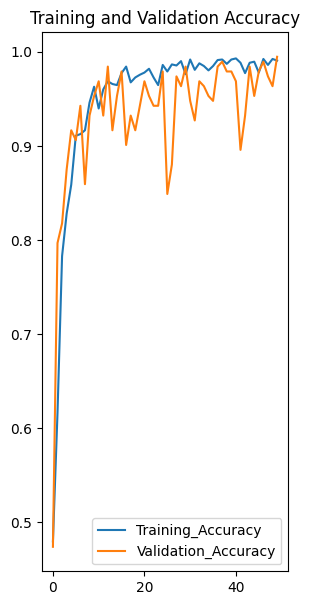

In [37]:
plt.figure(figsize = (7, 7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = 'Training_Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'Validation_Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

First image to predict: 
Predicted class: Potato___Late_blight


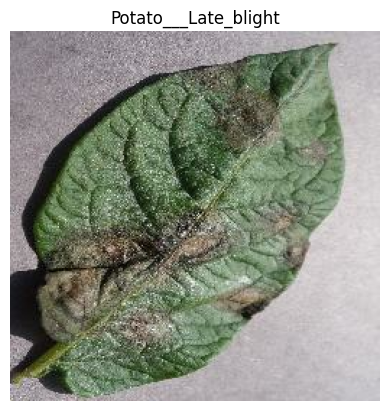

In [50]:
for images_batch, label_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_image_label = class_names[label_batch[0].numpy()]
    
    print('First image to predict: ')
    plt.imshow(first_image)
    plt.axis("off")
    plt.title(first_image_label)
    
    predictions = model.predict(images_batch)
    print(f'Predicted class: {class_names[np.argmax(predictions[0])]}')

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

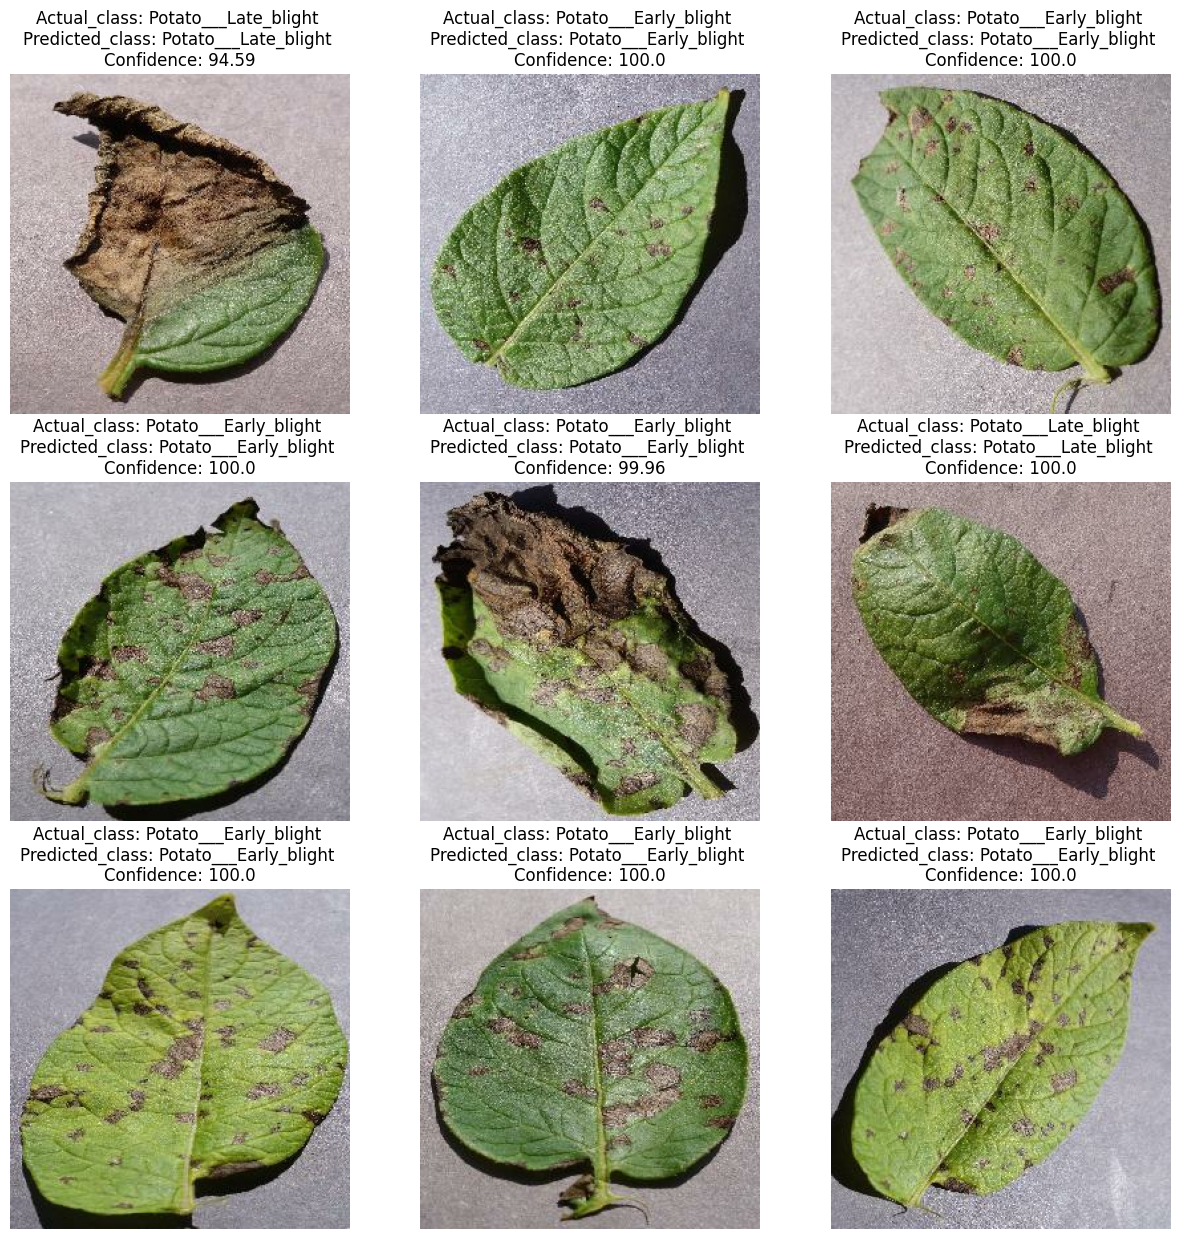

In [67]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual_class: {actual_class} \nPredicted_class: {predicted_class} \nConfidence: {confidence}')
        plt.axis("off")

In [71]:
# model_version = 1
# model.save(f'../models/{model_version}')

In [72]:
# Better Practise:As u keep changing the models, it is better to save it as different version rather than overwriting the previous one

# so....

In [73]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets
